# NMFによるスペクトル分離

ふたつのガウス分布（N(200, 100), N(350, 50))を混合させたものを100点用意し、
そのデータセットに対してNMFを試みた。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy import stats

In [2]:
x = np.arange(0, 500)
p1 = stats.norm.pdf(x=x, loc=200, scale=100)
p2 = stats.norm.pdf(x=x, loc=350, scale=50)

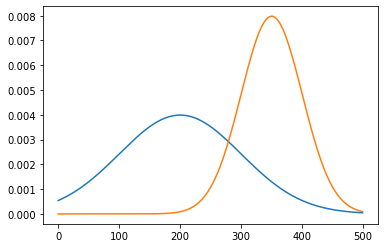

In [3]:
plt.plot(x, p1)
plt.plot(x, p2)
plt.show()

In [4]:
P = np.array([p1, p2]).T
M = np.random.rand(2, 100)

# Sampling from Multivariate normal
mean = np.array([3, 3])
cov = np.array([[1, -0.7]
               ,[-0.7, 1]])
M_ = np.random.multivariate_normal(mean, cov, size=100).T
M = M_

Y = P @ M

ピークを混合させる：

$y_i = t_1 \cdot p_{1,i} + t_1 \cdot p_{2,i}$

ただし、$t_1, t_2$ は：

1. 互いに独立した一様分布 $[0, 1)$ からサンプリング
2. 分散 1, 共分散 -0.7 の2変量正規分布からサンプリング

→ 面白そうなので、2. で実施。

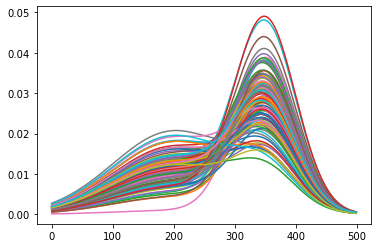

In [5]:
df = pd.DataFrame(Y).T
for index in df.index:
    plt.plot(df.loc[index, :], label=index)
# plt.legend()
plt.show()

In [6]:
from sklearn.decomposition import NMF

In [7]:
NMF?

Init signature:
NMF(
    n_components=None,
    *,
    init=None,
    solver='cd',
    beta_loss='frobenius',
    tol=0.0001,
    max_iter=200,
    random_state=None,
    alpha=0.0,
    l1_ratio=0.0,
    verbose=0,
    shuffle=False,
)
Docstring:     
Non-Negative Matrix Factorization (NMF)

Find two non-negative matrices (W, H) whose product approximates the non-
negative matrix X. This factorization can be used for example for
dimensionality reduction, source separation or topic extraction.

The objective function is::

    0.5 * ||X - WH||_Fro^2
    + alpha * l1_ratio * ||vec(W)||_1
    + alpha * l1_ratio * ||vec(H)||_1
    + 0.5 * alpha * (1 - l1_ratio) * ||W||_Fro^2
    + 0.5 * alpha * (1 - l1_ratio) * ||H||_Fro^2

Where::

    ||A||_Fro^2 = \sum_{i,j} A_{ij}^2 (Frobenius norm)
    ||vec(A)||_1 = \sum_{i,j} abs(A_{ij}) (Elementwise L1 norm)

For multiplicative-update ('mu') solver, the Frobenius norm
(0.5 * ||X - WH||_Fro^2) can be changed into another beta-divergence loss,
by cha

# NMF 

In [8]:
n = min(len(df.index), len(df.columns))
beta_loss = ["frobenius", 'kullback-leibler', 'itakura-saito']
solver = ["cd", "mu"]
init = [None, 'random', 'nndsvd', 'nndsvda', 'nndsvdar', 'custom']

model = NMF(n_components=3, random_state=42, alpha=0, l1_ratio=0.7, max_iter=800
           ,init=None, solver=solver[0], beta_loss=beta_loss[0])
model.fit(df)
feature = pd.DataFrame(model.transform(df), index=df.index)
feature.columns = ["cmp{}".format(i) for i in range(1, len(feature.columns)+1)]
feature

,cmp1,cmp2,cmp3
0,0.127380,0.078598,0.0
1,0.196476,0.062886,0.0
2,0.154311,0.036412,0.0
3,0.138122,0.139125,0.0
4,0.131774,0.105006,0.0
...,...,...,...
95,0.244389,0.060310,0.0
96,0.169796,0.101149,0.0
97,0.174899,0.068452,0.0
98,0.081012,0.101703,0.0


In [9]:
components = pd.DataFrame(model.components_, index=["cmp{}".format(i) for i in range(1, len(model.components_)+1)])

In [10]:
model.reconstruction_err_

0.00016203951225802823

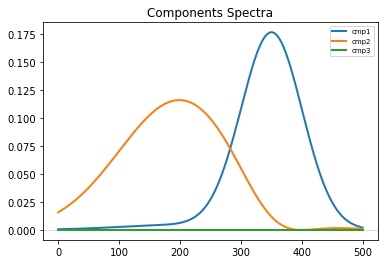

In [11]:
cmp = components
plt.axhline(y=0, xmin=0, xmax=1, color="#dddddd", linewidth=1)
for ind in cmp.index[:]:
    plt.plot(cmp.loc[ind, :], label=ind, linewidth=2)
plt.title("Components Spectra")
plt.legend(fontsize=7)
plt.show()

※ もとのピーク再掲

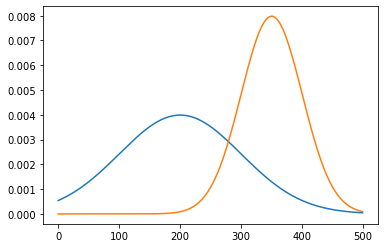

In [12]:
plt.plot(x, p1)
plt.plot(x, p2)
plt.show()

In [13]:
feature.shape

(100, 3)

## CMP-CMP plot

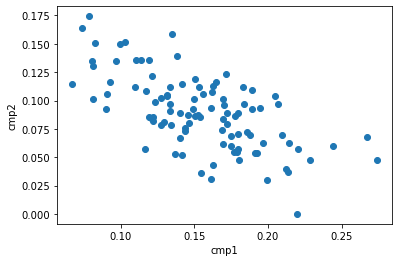

In [14]:
x = "cmp1"
y = "cmp2"
plotted = feature
plt.scatter(plotted[x], plotted[y])
# plt.legend(fontsize=7)
plt.xlabel(x)
plt.ylabel(y)
plt.show()

## もとの振幅のプロット 

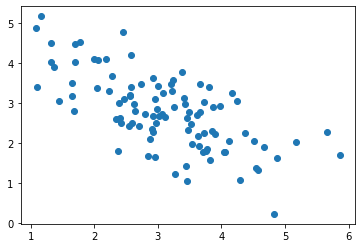

In [15]:
plt.scatter(M[1], M[0])
plt.show()

# cf. PCA

In [16]:
from sklearn.decomposition import PCA

model = PCA(n_components=None, random_state=42)
model.fit(df)
feature = pd.DataFrame(model.transform(df), index=df.index)
feature.columns = ["cmp{}".format(i) for i in range(1, len(feature.columns)+1)]
feature.iloc[:, :4]

,cmp1,cmp2,cmp3,cmp4
0,-0.034404,-0.037602,5.932804e-19,-1.758052e-18
1,0.072421,-0.003080,3.863006e-18,1.026806e-17
2,0.021191,-0.075581,-8.353157e-17,1.301175e-17
3,-0.042169,0.057576,1.507783e-16,-1.420664e-17
4,-0.038219,0.003683,6.550873e-17,-7.051493e-18
...,...,...,...,...
95,0.143278,0.032723,2.828402e-17,1.893061e-17
96,0.018711,0.029509,7.892717e-17,-4.638188e-19
97,0.038808,-0.012920,7.363079e-18,6.795891e-18
98,-0.110953,-0.042853,2.541111e-17,-1.251700e-17


In [17]:
components = pd.DataFrame(model.components_, index=["cmp{}".format(i) for i in range(1, len(model.components_)+1)])

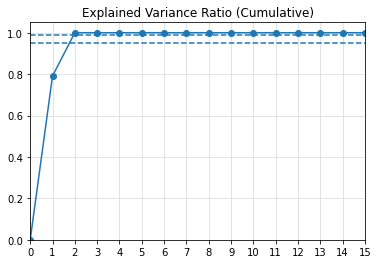

In [18]:
from itertools import accumulate
plt.plot([0] + list(accumulate(model.explained_variance_ratio_)), marker="o", markersize=6)
plt.title("Explained Variance Ratio (Cumulative)")
plt.axhline(y=0.99, xmin=0, xmax=20, linestyle="dashed")
plt.axhline(y=0.95, xmin=0, xmax=20, linestyle="dashed")

plt.xticks(range(0, 40, 1))
plt.ylim([0, 1.05])
plt.xlim([0, 15])
plt.grid(b=True, which='major', color='#dddddd', linestyle='-')
plt.show()

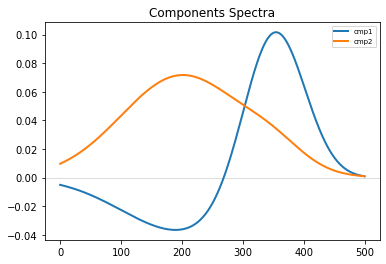

In [19]:
cmp = components
plt.axhline(y=0, xmin=0, xmax=1, color="#dddddd", linewidth=1)
for ind in cmp.index[:2]:
    plt.plot(cmp.loc[ind, :], label=ind, linewidth=2)
plt.title("Components Spectra")
plt.legend(fontsize=7)
plt.show()

In [20]:
feature.shape

(100, 100)

## CMP-CMP plot

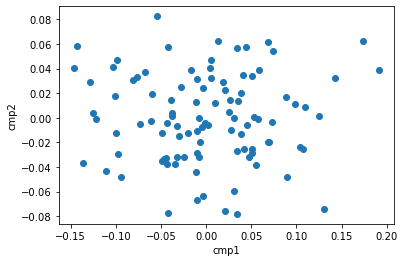

In [21]:
x = "cmp1"
y = "cmp2"
plotted = feature
plt.scatter(plotted[x], plotted[y])
# plt.legend(fontsize=7)
plt.xlabel(x)
plt.ylabel(y)
plt.show()